In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch 
import torch.nn as nn
import timm
from torchvision.transforms import transforms
from torch.utils.data import TensorDataset, DataLoader

from sklearn.cluster import KMeans

In [2]:
device = "cuda"
root_path = "/home/stefan/ioai-prep/kits/neoai-2025/cluster-images"
seed = 42
batch_size = 4

In [8]:
model = timm.create_model("tiny_vit_5m_224.dist_in22k_ft_in1k", pretrained=True, num_classes=0)
data_config = timm.data.resolve_model_data_config(model)

# Data

In [9]:
X_1 = np.load(f'{root_path}/data_1.npz')
X_1 = X_1.f.arr_0
X_2 = np.load(f'{root_path}/data_2.npz')
X_2 = X_2.f.arr_0
print(X_1.shape, X_2.shape)

def prepare_pseudo_images(X_1, X_2):
    X1t = torch.tensor(X_1)
    X2t = torch.tensor(X_2)
    
    images = torch.bmm(X1t, X2t)
    images = images[:, None, :, :]
    images = images.repeat(1, 3, 1, 1)

    transforms = timm.data.create_transform(**data_config, is_training=False)
    images = transforms(images)  
    return images

images = prepare_pseudo_images(X_1, X_2)
images.shape

(3840, 128, 4) (3840, 4, 128)


torch.Size([3840, 3, 224, 224])

In [10]:
dataset = TensorDataset(images)
dataloader = DataLoader(dataset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.9645824..1008.63043].


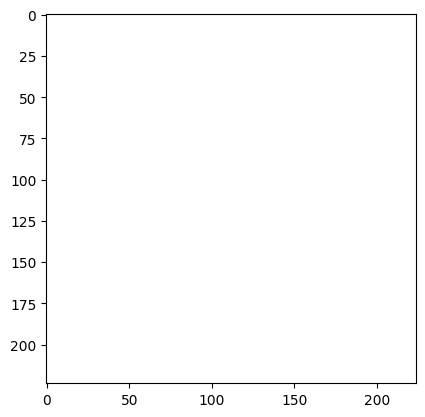

In [11]:
# sanity check
batch = next(iter(dataloader))[0]
plt.imshow(batch[0].squeeze(0).permute(1, 2, 0))

# Model

In [12]:
class EmbNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("tiny_vit_5m_224.dist_in22k_ft_in1k", pretrained=True, num_classes=0)

    def forward(self, image):
        x = self.model(image)
        return x

emb_net = EmbNet().to(device)
emb_net.eval()

emb_net

EmbNet(
  (model): TinyVit(
    (patch_embed): PatchEmbed(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): GELU(approximate='none')
      (conv2): ConvNorm(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): Sequential(
      (0): ConvLayer(
        (blocks): Sequential(
          (0): MBConv(
            (conv1): ConvNorm(
              (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): ConvNorm(
              (conv): Conv2d(256, 256, kernel_si

In [13]:
emb_net(batch.to(device)).shape

torch.Size([4, 320])

# Prepare

In [14]:
km = KMeans(32, random_state=seed)

In [15]:
X = None

for batch in tqdm(dataloader):
    with torch.no_grad():
        features = emb_net(batch[0].to(device)).cpu().numpy()

    if X is None:
        X = features
    else:
        X = np.concat([X, features])

X.shape

100%|██████████| 960/960 [00:07<00:00, 125.81it/s]


(3840, 320)

In [16]:
pred_cluster = km.fit_predict(X)

# Submission

In [17]:
def generate_submit(pred_cluster):
    import hashlib
    sub = pd.DataFrame()
    sub['id'] = np.arange(len(pred_cluster))
    sub['target'] = pred_cluster
    hsh = hashlib.sha256(sub.to_csv(index=False).encode('utf-8')).hexdigest()[:8]
    submit_path = f"submission_{hsh}.csv"
    print(f"SUBMIT_NAME: {submit_path}")
    sub.to_csv(submit_path, index = None)

generate_submit(pred_cluster)

SUBMIT_NAME: submission_96711daa.csv
